# ts genealogies
Infer genealogies with pure-magenta vs pure-yellow high coverage samples from MF and YF

In [242]:
import tsinfer
import tsdate
import tskit
import cyvcf2
import numpy as np
import os
import pandas as pd
import msprime
from IPython.display import SVG, display
import matplotlib.pyplot as plt

In [101]:
 ts = msprime.sim_ancestry(
        samples=3,
        recombination_rate=1e-8,
        sequence_length=5_000,
        population_size=10_000,
        random_seed=123456)

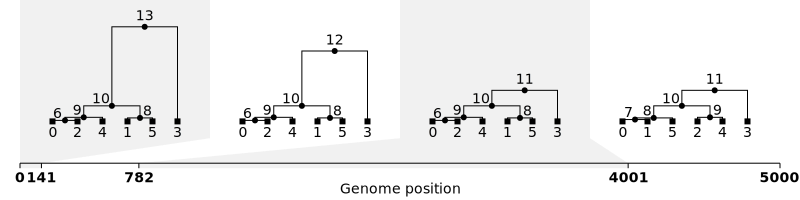

In [106]:
SVG(ts.draw_svg())

In [112]:
tree1 = ts.first()
tree1.time(tree1.mrca(0,2))

740.0873279546317

In [115]:
div = ts.divergence_matrix(mode='branch', samples=ts.samples(), windows=[i for i in ts.breakpoints()])
print(div[0,:,:])

[[     0.          22962.68768088   1480.17465591 139579.33284442
    6018.12993266  22962.68768088]
 [ 22962.68768088      0.          22962.68768088 139579.33284442
   22962.68768088   5142.36482986]
 [  1480.17465591  22962.68768088      0.         139579.33284442
    6018.12993266  22962.68768088]
 [139579.33284442 139579.33284442 139579.33284442      0.
  139579.33284442 139579.33284442]
 [  6018.12993266  22962.68768088   6018.12993266 139579.33284442
       0.          22962.68768088]
 [ 22962.68768088   5142.36482986  22962.68768088 139579.33284442
   22962.68768088      0.        ]]


In [2]:
# os.chdir('/Users/apal/Phd/Projects/2021-snap_hap/ARGs')
os.chdir('/nfs/scistore18/bartogrp/apal/snap_hap/ARGs')
os.getcwd()

'/nfs/scistore18/bartogrp/apal/snap_hap/ARGs'

In [3]:
## Define function to add sites into samples for tsinfer
def add_diploid_sites(vcf, samples):
    
    """
    Read the sites in the vcf and add them to the samples object.
    """
    
    # You may want to change the following line, e.g. here we allow
    # "*" (a spanning deletion) to be a valid allele state
    allele_chars = set("ATGCatgc*")
    pos = 0
    siteID = 0
    
    for variant in vcf:  # Loop over variants, each assumed at a unique site    
        # progressbar.update(variant.POS - pos)
        allele_chars = set("ATGCatgc*")
        
        pos = variant.POS
        
        alleles = [variant.REF.upper()] + [v.upper() for v in variant.ALT]
        ancestral_allele = 0
        
        # ancestral = variant.INFO.get("AA", ".")  # "." means unknown
        
        # # some VCFs (e.g. from 1000G) have many values in the AA field: take the 1st
        # ancestral = ancestral.split("|")[0].upper()
        # if ancestral == "." or ancestral == "":
        #     ancestral_allele = MISSING_DATA
        #     # alternatively, you could specify `ancestral = variant.REF.upper()`
        # else:
        #     ancestral_allele = alleles.index(ancestral)
    
        # Check we have ATCG alleles
        for a in alleles:
            if len(set(a) - allele_chars) > 0:
                print(f"Ignoring site at pos {pos}: allele {a} not in {allele_chars}")
                continue
        # Map original allele indexes to their indexes in the new alleles list.
        genotypes = [g for row in variant.genotypes for g in row[0:2]]

        samples.add_site(pos, genotypes, alleles, ancestral_allele=ancestral_allele)
        siteID += 1

In [4]:
##  Load samples to tsinfer
demes=['pmFR','pyYe']
demeSize = [45, 50]
popList = np.repeat(demes, demeSize)
vcf_path="./VCFs/Am_pmFRpyYe-hCov_stitchRun1_Chr6-52800000-53200000.refScaf.statphased.vcf.gz"
vcf = cyvcf2.VCF(vcf_path)

In [5]:
with tsinfer.SampleData(path = './ts_run3-20240603_pmFRpyYe-hCov/ts.RosEl.pmFRpyYe.samples') as sample_data:
    
    ## Define populations
    sample_data.add_population(metadata={"name": "pmFR"})
    sample_data.add_population(metadata={"name": "pyYe"})

    ## Define inidividuals
    for sampleName, pop in zip(vcf.samples, popList):
        popIndex = demes.index(pop)
        sample_data.add_individual(ploidy=2, population=popIndex, metadata={"names":sampleName})

    ## Add sites and genotypes
    add_diploid_sites(vcf, sample_data)

In [6]:
## Load sample data if run before
sample_data = tsinfer.load('./ts_run3-20240603_pmFRpyYe-hCov/ts.RosEl.pmFRpyYe.samples')

In [7]:
# sample_data.
sample_data.num_samples

190

In [8]:
print(
    "Sample file created for {} samples ".format(sample_data.num_samples)
    + "({} individuals) ".format(sample_data.num_individuals)
    + "with {} variable sites.".format(sample_data.num_sites),
    flush=True,
)

Sample file created for 190 samples (95 individuals) with 23529 variable sites.


In [9]:
ts_rosel_pmFRpyYe = tsinfer.infer(sample_data)
tsSimp_rosel_pmFRpyYe = ts_rosel_pmFRpyYe.simplify(keep_unary=False)
tsD_rosel_pmFRpyYe = tsdate.date(tsSimp_rosel_pmFRpyYe, Ne=354349, mutation_rate=7e-9)

In [10]:
tsD_rosel_pmFRpyYe

In [12]:
## Save the tree sequence
tsD_rosel_pmFRpyYe.dump('./ts_run3-20240603_pmFRpyYe-hCov/ts.RosEl.pmFRpyYe.trees')

## Load tree sequence
# tsD_rosel_mFRyYe = tskit.load('./ts_run2-20240522_FrYe/ts.RosEl.mFRyYe.ts')

In [13]:
treeStart = []
treeEnd = []
treeSpan = []
treeList = []

for tree in tsD_rosel_pmFRpyYe.trees():
    if (tree.interval.left > 0):
        treeStart.append(tree.interval.left)
        treeEnd.append(tree.interval.right)
        treeSpan.append(tree.span)
        # treeList.append(tree.as_newick(root=tree.roots))
        treeList.append(tree.as_newick(root=tree.root))

tsDF = pd.DataFrame({'treeStart': treeStart,
                      'treeEnd': treeEnd,
                     'treeSpan': treeSpan,
                     'tree': treeList})
tsDF.to_csv('./ts_run3-20240603_pmFRpyYe-hCov/ts.RosEl.trList.newick.txt',
            sep="\t", quoting = None, index = False, encoding = 'utf-8')

## Analyse trees

In [18]:
pmFR = [range(0,89)]
pyYe = [range(90,189)]

In [93]:
tr = tsD_rosel_pmFRpyYe.at_index(1)

In [38]:
node_colors = {}
for sample in pmFR[:]:
    node_colors[sample] = {"fill": 'magenta'}
# for sample in pyYe:
#     node_colors[sample] = {"fill": 'yellow'}

In [423]:
print(list(range(162, 190)))
len(list(range(162, 190)))

[162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189]


28

In [424]:
# Create dictionary with keys 1-10 being 'blue'
blue_dict = {key: 'plum' for key in range(0, 90)}

MF1_dict = {key: 'plum' for key in range(0, 38)}
MF2_dict = {key: 'magenta' for key in range(38, 64)}
MF3_dict = {key: 'purple' for key in range(64, 90)}

# Create dictionary with keys 11-20 being 'red'
# red_dict = {key: 'gold' for key in range(91, 190)}
YF1_dict = {key: 'gold' for key in range(90, 124)}
YF2_dict = {key: 'orange' for key in range(124, 162)}
YF3_dict = {key: 'olive' for key in range(162, 190)}

# Combine both dictionaries
# combined_dict = {**blue_dict, **red_dict}
combined_dict = {**MF1_dict, **MF2_dict, **MF3_dict, **YF1_dict, **YF2_dict, **YF3_dict}

# Print the combined dictionary
print(combined_dict)

{0: 'plum', 1: 'plum', 2: 'plum', 3: 'plum', 4: 'plum', 5: 'plum', 6: 'plum', 7: 'plum', 8: 'plum', 9: 'plum', 10: 'plum', 11: 'plum', 12: 'plum', 13: 'plum', 14: 'plum', 15: 'plum', 16: 'plum', 17: 'plum', 18: 'plum', 19: 'plum', 20: 'plum', 21: 'plum', 22: 'plum', 23: 'plum', 24: 'plum', 25: 'plum', 26: 'plum', 27: 'plum', 28: 'plum', 29: 'plum', 30: 'plum', 31: 'plum', 32: 'plum', 33: 'plum', 34: 'plum', 35: 'plum', 36: 'plum', 37: 'plum', 38: 'magenta', 39: 'magenta', 40: 'magenta', 41: 'magenta', 42: 'magenta', 43: 'magenta', 44: 'magenta', 45: 'magenta', 46: 'magenta', 47: 'magenta', 48: 'magenta', 49: 'magenta', 50: 'magenta', 51: 'magenta', 52: 'magenta', 53: 'magenta', 54: 'magenta', 55: 'magenta', 56: 'magenta', 57: 'magenta', 58: 'magenta', 59: 'magenta', 60: 'magenta', 61: 'magenta', 62: 'magenta', 63: 'magenta', 64: 'purple', 65: 'purple', 66: 'purple', 67: 'purple', 68: 'purple', 69: 'purple', 70: 'purple', 71: 'purple', 72: 'purple', 73: 'purple', 74: 'purple', 75: 'purp

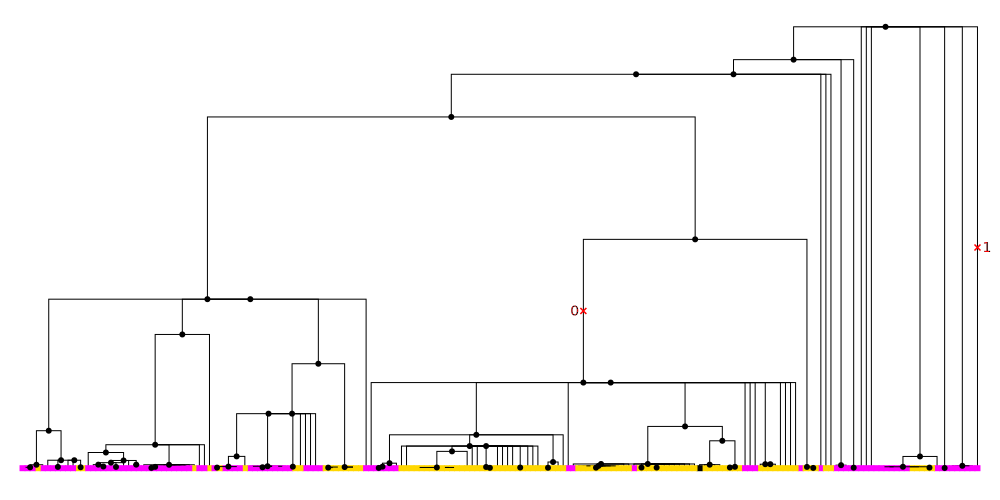

In [95]:
tr.draw(height=500, width=1000, time_scale='time', node_labels={}, node_colours=combined_dict)

In [84]:
# tsD_rosel_pmFRpyYe.divergence_matrix(mode='branch', samples=tsD_rosel_pmFRpyYe.samples(), windows=[i for i in tsD_rosel_pmFRpyYe.breakpoints()])
# divergence_w_pmFR = tsD_rosel_pmFRpyYe.divergence_matrix(mode='branch', samples=tsD_rosel_pmFRpyYe.samples()[:90], windows=[i for i in tsD_rosel_pmFRpyYe.breakpoints()])
# divergence_w_pyYe = tsD_rosel_pmFRpyYe.divergence_matrix(mode='branch', samples=tsD_rosel_pmFRpyYe.samples()[90:], windows=[i for i in tsD_rosel_pmFRpyYe.breakpoints()])
divergence_all = tsD_rosel_pmFRpyYe.divergence_matrix(mode='branch', samples=tsD_rosel_pmFRpyYe.samples(), windows=[i for i in tsD_rosel_pmFRpyYe.breakpoints()])

In [87]:
divergence_all.shape

(13993, 190, 190)

In [83]:
divmat.shape

(1, 90, 90)

In [118]:
tr.time(tr.mrca(0,1))*2

1919444.8518807378

In [117]:
print(np.matrix(divergence_all[1,0:5,0:5]))

[[      0.         1919444.85188074  163043.42313288 1919444.85188074
  1776580.87156341]
 [1919444.85188074       0.         1919444.85188074 1919444.85188074
  1919444.85188074]
 [ 163043.42313288 1919444.85188074       0.         1919444.85188074
  1776580.87156341]
 [1919444.85188074 1919444.85188074 1919444.85188074       0.
  1919444.85188074]
 [1776580.87156341 1919444.85188074 1776580.87156341 1919444.85188074
        0.        ]]


In [81]:
divmat[0,:,:]

array([[      0.        , 1919444.85188074,  163043.42313288, ...,
        1527446.71373553, 1527446.71373553, 1527446.71373553],
       [1919444.85188074,       0.        , 1919444.85188074, ...,
        1919444.85188074, 1919444.85188074, 1919444.85188074],
       [ 163043.42313288, 1919444.85188074,       0.        , ...,
        1527446.71373553, 1527446.71373553, 1527446.71373553],
       ...,
       [1527446.71373553, 1919444.85188074, 1527446.71373553, ...,
              0.        ,  372355.74084528,  372355.74084528],
       [1527446.71373553, 1919444.85188074, 1527446.71373553, ...,
         372355.74084528,       0.        ,   18390.4066253 ],
       [1527446.71373553, 1919444.85188074, 1527446.71373553, ...,
         372355.74084528,   18390.4066253 ,       0.        ]])

In [63]:
[i for i in tsD_rosel_pmFRpyYe.breakpoints()][1:3]

[52800008.0, 52800099.0]

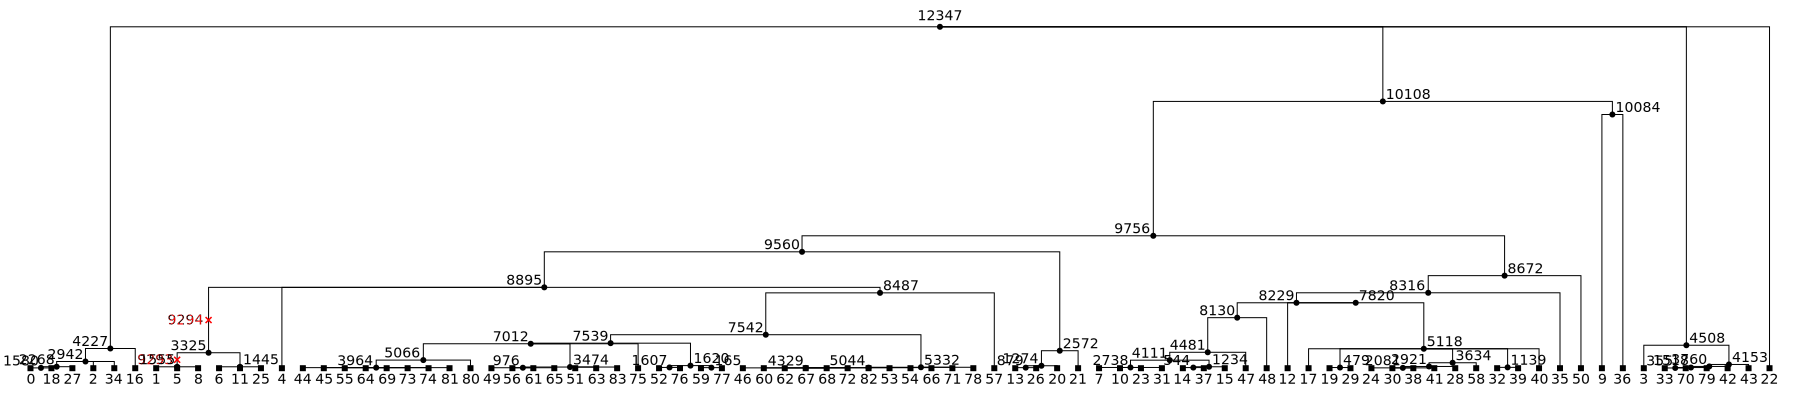

In [34]:
tr.draw(node_colours=node_colors, width=1800, height=400)

In [31]:
rt = tr.root
tr.time(rt)

1550634.4235430695

In [63]:
print(pmFR)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88]


In [83]:
trID=1000
tr = tsD_rosel_mFRyYe.at_index(trID)
tr.mrca()

ValueError: Must supply at least two arguments

In [61]:
TMRCA_b = []
TMRCA_w_pmFR = []
TMRCA_w_pyYe = []

for trID in range(1,tsD_rosel_mFRyYe.num_trees):
    tr = tsD_rosel_mFRyYe.at_index(trID)
    TMRCA_b.append(tr.time(tr.root))
    TMRCA_w_pmFR.append(tr.time(tr.mrca(pmFR)))
    TMRCA_w_pyYe.append(tr.time(tr.mrca(pyYe)))

ValueError: Must supply at least two arguments

In [46]:
[tr.num_roots for tr in tsD_rosel_mFRyYe.trees()]

[84,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,

In [55]:
range(1, tsD_rosel_mFRyYe.num_trees)

10427

In [57]:
tr =  tsD_rosel_mFRyYe.first()
tr.interval

Interval(left=0.0, right=52800008.0)

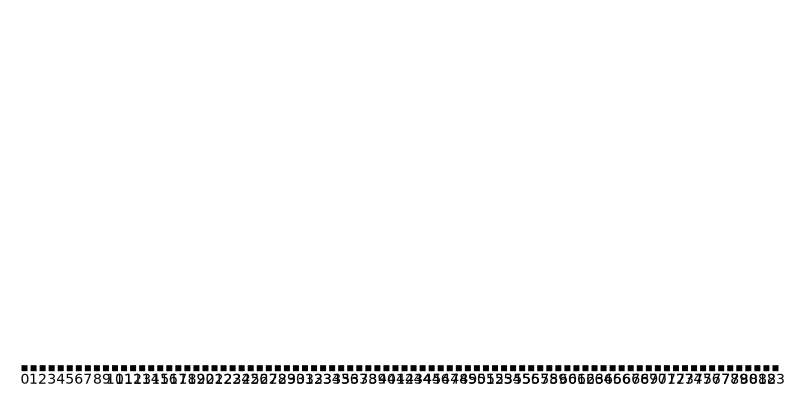

In [56]:
tr.draw_svg(size=(800,400))

In [ ]:
test = tsD_rosel_pmFRpyYe.divergence_matrix(mode='branch', samples=tsD_rosel_pmFRpyYe.samples()[], windows=[i for i in tsD_rosel_pmFRpyYe.breakpoints()])

In [215]:
tsD_rosel_pmFRpyYe.samples()[0:10:2]

array([0, 2, 4, 6, 8], dtype=int32)

In [221]:
## Calculate TMRCA_between and TMRCA_within

div = divergence_all[1,:,:]
# a.sum()/(int(a.size) - a.shape[1])

In [490]:
divergence_all.shape

(13993, 190, 190)

In [492]:
# np.set_printoptions(precision=2)
meanTMRCA_b = []
minTMRCA_b = []
maxTMRCA_b = []

meanTMRCA_w_pyYe = []
minTMRCA_w_pyYe = []
maxTMRCA_w_pyYe = []

meanTMRCA_w_pmFR = []
minTMRCA_w_pmFR = []
maxTMRCA_w_pmFR = []

for i in range(1, 13993):
    div = divergence_all[i,:,:]
    
    div_w_pmFR = div[:90,:90].flatten()
    div_w_pmFR = [time for i, time in enumerate(div_w_pmFR) if time!= 0]
    # meanTMRCA_w_pmFR.append(div_w_pmFR.sum()/(int(div_w_pmFR.size)-div_w_pmFR.shape[0]))
    meanTMRCA_w_pmFR.append(np.mean(div_w_pmFR))
    maxTMRCA_w_pmFR.append(np.max(div_w_pmFR))
    minTMRCA_w_pmFR.append(np.min(div_w_pmFR))
    
    div_w_pyYe = div[90:,90:].flatten()
    div_w_pyYe = [time for i, time in enumerate(div_w_pyYe) if time!= 0]
    # meanTMRCA_w_pyYe.append(div_w_pyYe.sum()/(int(div_w_pyYe.size)-div_w_pyYe.shape[0]))
    meanTMRCA_w_pyYe.append(np.mean(div_w_pyYe))
    maxTMRCA_w_pyYe.append(np.max(div_w_pyYe))
    minTMRCA_w_pyYe.append(np.min(div_w_pyYe))
    
    div_b = div[90:,:90]
    meanTMRCA_b.append(np.mean(div_b))
    maxTMRCA_b.append(np.max(div_b))
    minTMRCA_b.append(np.min(div_b))

In [305]:
Ne=354349
meanTMRCA_b[:] = [x / (4*Ne) for x in meanTMRCA_b]
meanTMRCA_w_pmFR[:] = [x / (4*Ne) for x in meanTMRCA_w_pmFR]
meanTMRCA_w_pyYe[:] = [x / (4*Ne) for x in meanTMRCA_w_pyYe]

In [495]:
pos = [i for i in tsD_rosel_pmFRpyYe.breakpoints()][1:]
pos[:] = [x / 1e6 for x in pos]

In [493]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

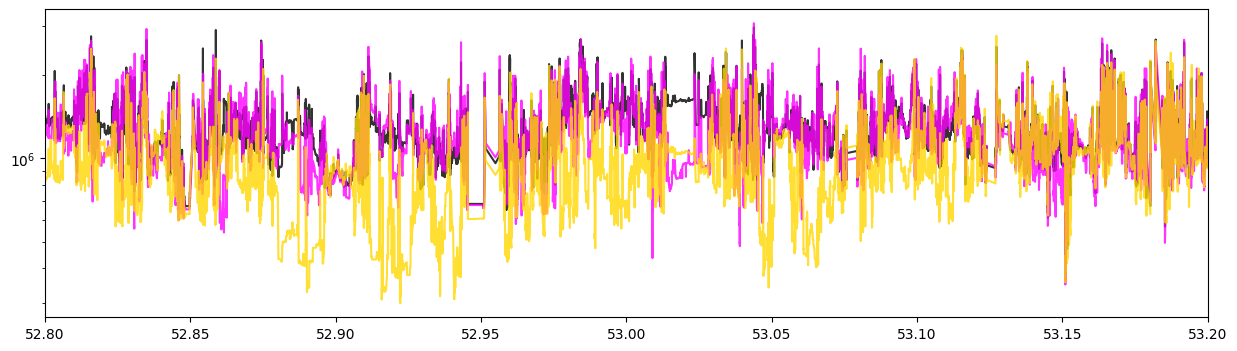

In [501]:
plt.figure(figsize=(15,4))
plt.plot(pos[1:], meanTMRCA_b[:], color='black', alpha=0.8)
plt.plot(pos[1:], meanTMRCA_w_pmFR[:], alpha=0.8, color='magenta')
plt.plot(pos[1:], meanTMRCA_w_pyYe[:], alpha=0.8, color='gold')
plt.yscale('log')
# plt.plot(list(range(50,55,1)), [0.3]*5, 'b--')
plt.xlim(52.80,53.20)

plt.show()

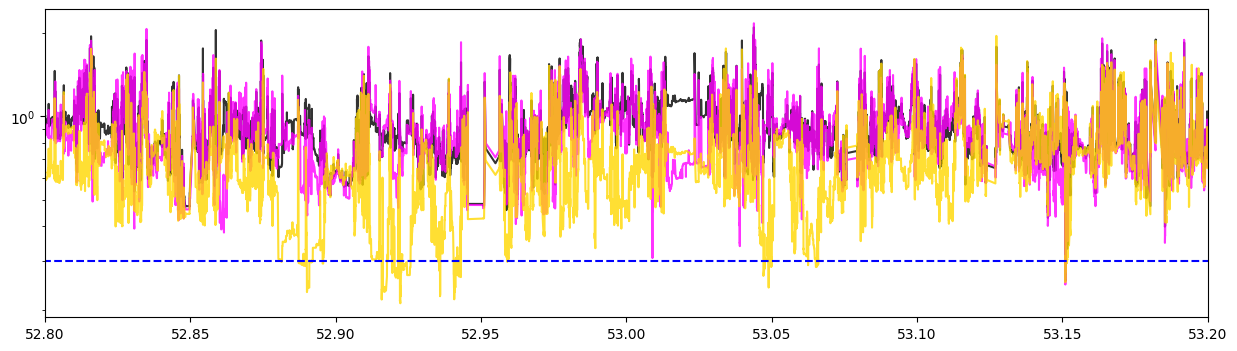

In [427]:
plt.figure(figsize=(15,4))
plt.plot(pos[1:], meanTMRCA_b[1:], color='black', alpha=0.8)
plt.plot(pos[1:], meanTMRCA_w_pmFR[1:], alpha=0.8, color='magenta')
plt.plot(pos[1:], meanTMRCA_w_pyYe[1:], alpha=0.8, color='gold')
plt.yscale('log')
plt.plot(list(range(50,55,1)), [0.3]*5, 'b--')
plt.xlim(52.80,53.20)

plt.show()

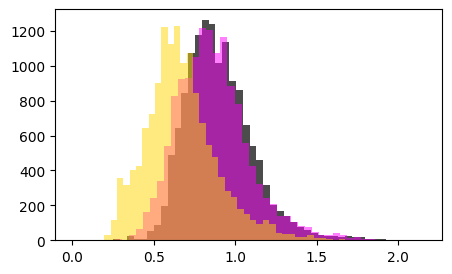

In [363]:
plt.figure(figsize=(5,3))
plt.hist(meanTMRCA_b, color='black', alpha=0.7, bins=50)
plt.hist(meanTMRCA_w_pmFR, color='magenta', alpha=0.5, bins=50)
plt.hist(meanTMRCA_w_pyYe, color='gold', alpha=0.5, bins=50)

plt.show()

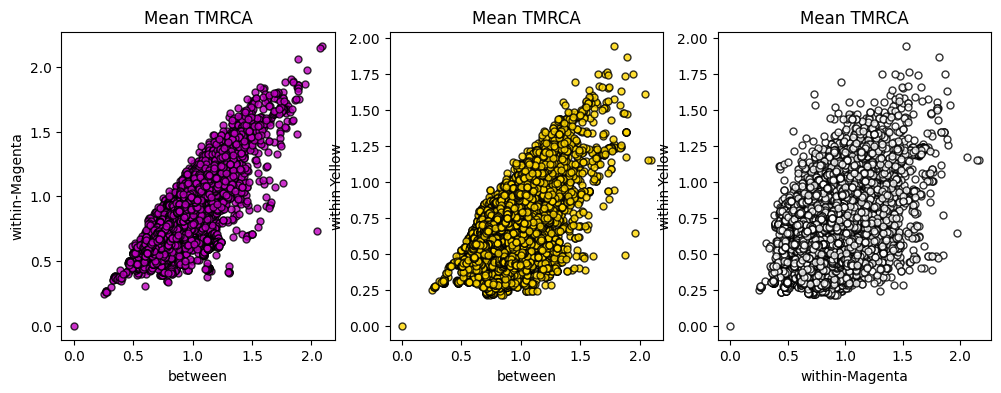

In [356]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(meanTMRCA_b, meanTMRCA_w_pmFR, 'o', color='m', markeredgecolor='black', markersize=5, alpha=0.8)
plt.title('Mean TMRCA')
plt.xlabel('between')
plt.ylabel('within-Magenta')

plt.subplot(1,3,2)
plt.plot(meanTMRCA_b, meanTMRCA_w_pyYe, 'o', color='gold', markeredgecolor='black', markersize=5, alpha=0.8)
plt.title('Mean TMRCA')
plt.xlabel('between')
plt.ylabel('within-Yellow')

plt.subplot(1,3,3)
plt.plot(meanTMRCA_w_pmFR, meanTMRCA_w_pyYe, 'o', color='w', markeredgecolor='black', markersize=5, alpha=0.8)
plt.title('Mean TMRCA')
plt.xlabel('within-Magenta')
plt.ylabel('within-Yellow')
abline=(1,0)

plt.show()

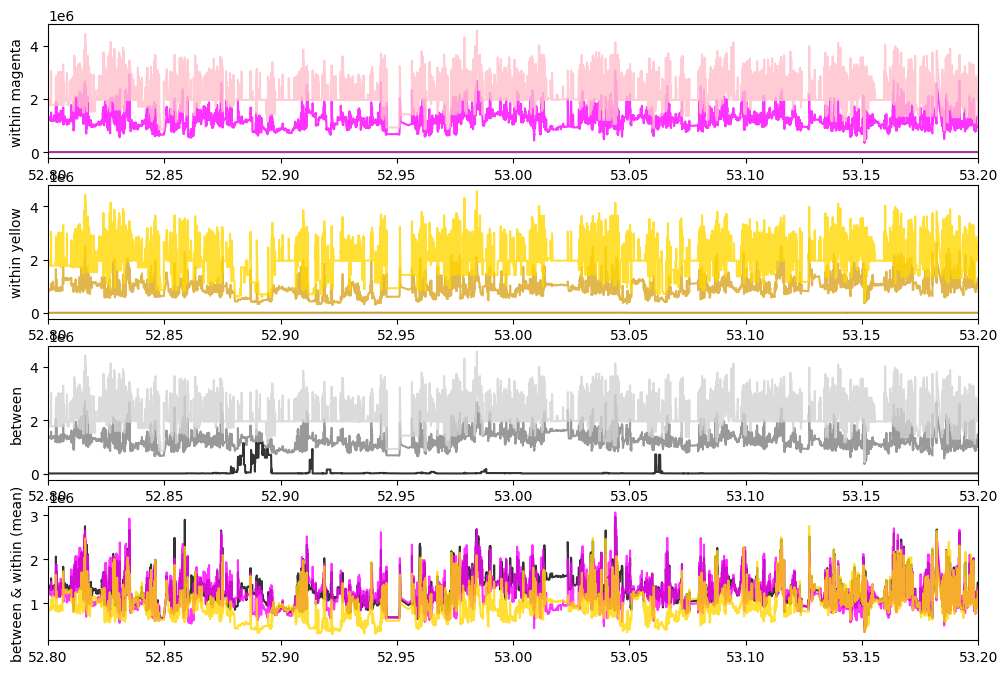

In [521]:
plt.figure(figsize=(12,8))

plt1 = plt.subplot(411)
plt.plot(pos[1:], meanTMRCA_w_pmFR[:], alpha=0.8, color='magenta')
plt.plot(pos[1:], maxTMRCA_w_pmFR[:], alpha=0.8, color='pink')
plt.plot(pos[1:], minTMRCA_w_pmFR[:], alpha=0.8, color='darkmagenta')
# plt.yscale('log')
plt.xlim(52.80,53.20)
plt.ylabel('within magenta')

plt2 = plt.subplot(412, sharex=plt1, sharey=plt1)
plt.plot(pos[1:], meanTMRCA_w_pyYe[:], alpha=0.8, color='goldenrod')
plt.plot(pos[1:], maxTMRCA_w_pyYe[:], alpha=0.8, color='gold')
plt.plot(pos[1:], minTMRCA_w_pyYe[:], alpha=0.8, color='darkgoldenrod')
# plt.yscale('log')
# plt.xlim(52.80,53.20)
plt.ylabel('within yellow')

plt3 = plt.subplot(413, sharex=plt1, sharey=plt1)
plt.plot(pos[1:], meanTMRCA_b[:], alpha=0.8, color='grey')
plt.plot(pos[1:], maxTMRCA_b[:], alpha=0.8, color='lightgrey')
plt.plot(pos[1:], minTMRCA_b[:], alpha=0.8, color='black')
# plt.yscale('log')
# plt.xlim(52.80,53.20)
plt.ylabel('between')

plt3 = plt.subplot(414, sharex=plt1,)
plt.plot(pos[1:], meanTMRCA_b[:], color='black', alpha=0.8)
plt.plot(pos[1:], meanTMRCA_w_pmFR[:], alpha=0.8, color='magenta')
plt.plot(pos[1:], meanTMRCA_w_pyYe[:], alpha=0.8, color='gold')
# plt.yscale('log')
plt.xlim(52.80,53.20)
plt.ylabel('between & within (mean
)')

plt.show()

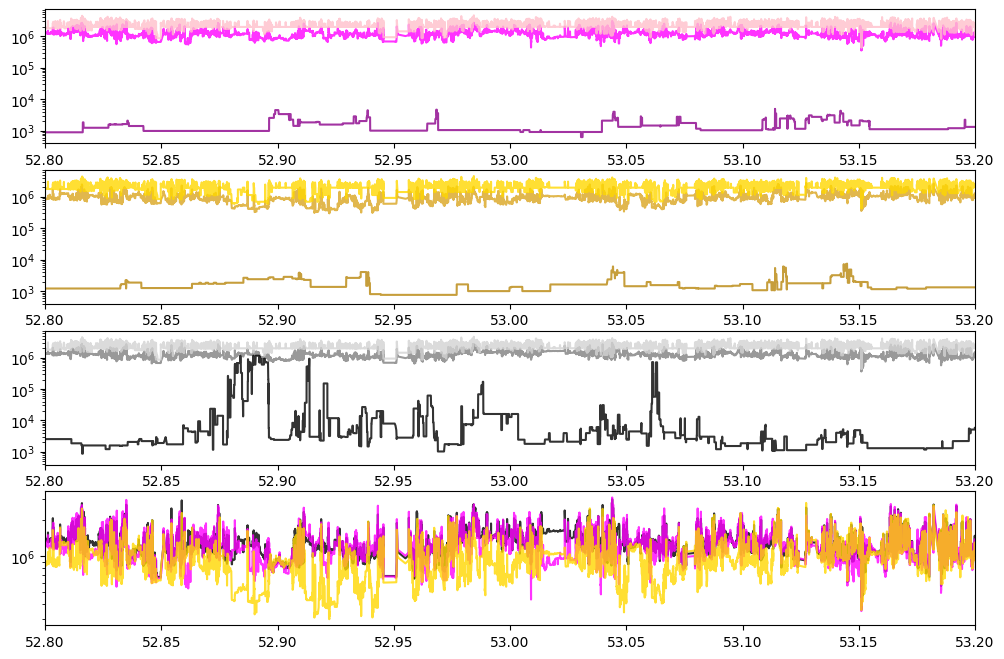

In [518]:
plt.figure(figsize=(12,8))

plt1 = plt.subplot(411)
plt.plot(pos[1:], meanTMRCA_w_pmFR[:], alpha=0.8, color='magenta')
plt.plot(pos[1:], maxTMRCA_w_pmFR[:], alpha=0.8, color='pink')
plt.plot(pos[1:], minTMRCA_w_pmFR[:], alpha=0.8, color='darkmagenta')
plt.yscale('log')
plt.xlim(52.80,53.20)

plt2 = plt.subplot(412, sharex=plt1, sharey=plt1)
plt.plot(pos[1:], meanTMRCA_w_pyYe[:], alpha=0.8, color='goldenrod')
plt.plot(pos[1:], maxTMRCA_w_pyYe[:], alpha=0.8, color='gold')
plt.plot(pos[1:], minTMRCA_w_pyYe[:], alpha=0.8, color='darkgoldenrod')
plt.yscale('log')
# plt.xlim(52.80,53.20)

plt3 = plt.subplot(413, sharex=plt1, sharey=plt1)
plt.plot(pos[1:], meanTMRCA_b[:], alpha=0.8, color='grey')
plt.plot(pos[1:], maxTMRCA_b[:], alpha=0.8, color='lightgrey')
plt.plot(pos[1:], minTMRCA_b[:], alpha=0.8, color='black')
plt.yscale('log')
# plt.xlim(52.80,53.20)

plt3 = plt.subplot(414, sharex=plt1,)
plt.plot(pos[1:], meanTMRCA_b[:], color='black', alpha=0.8)
plt.plot(pos[1:], meanTMRCA_w_pmFR[:], alpha=0.8, color='magenta')
plt.plot(pos[1:], meanTMRCA_w_pyYe[:], alpha=0.8, color='gold')
plt.yscale('log')
plt.xlim(52.80,53.20)

plt.show()

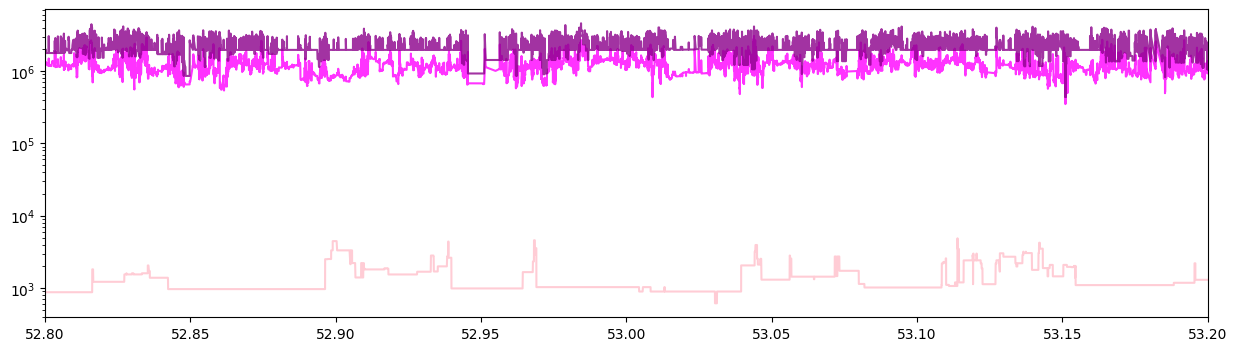

In [503]:
plt.figure(figsize=(15,4))

plt.plot(pos[1:], meanTMRCA_w_pmFR[:], alpha=0.8, color='magenta')
plt.plot(pos[1:], maxTMRCA_w_pmFR[:], alpha=0.8, color='darkmagenta')
plt.plot(pos[1:], minTMRCA_w_pmFR[:], alpha=0.8, color='pink')

plt.yscale('log')
# plt.plot(list(range(50,55,1)), [0.3]*5, 'b--')
plt.xlim(52.80,53.20)

plt.show()

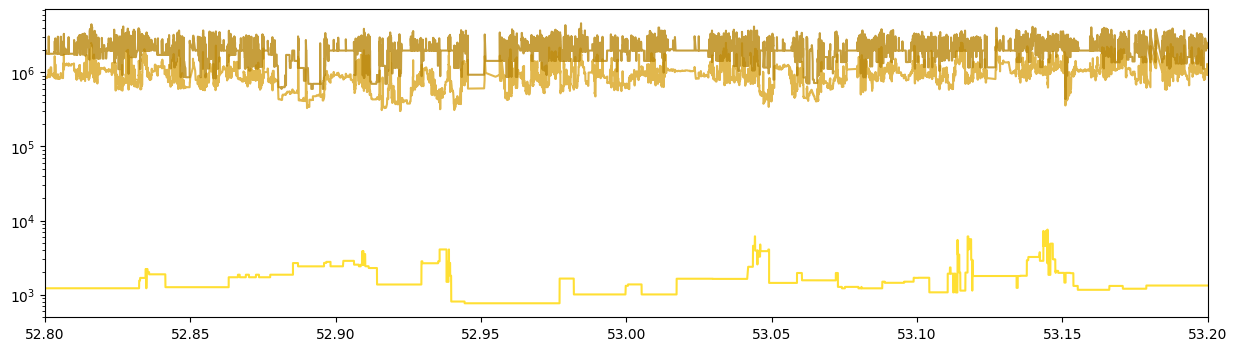

In [506]:
plt.figure(figsize=(15,4))

plt.plot(pos[1:], meanTMRCA_w_pyYe[:], alpha=0.8, color='goldenrod')
plt.plot(pos[1:], maxTMRCA_w_pyYe[:], alpha=0.8, color='darkgoldenrod')
plt.plot(pos[1:], minTMRCA_w_pyYe[:], alpha=0.8, color='gold')

plt.yscale('log')
# plt.plot(list(range(50,55,1)), [0.3]*5, 'b--')
plt.xlim(52.80,53.20)

plt.show()

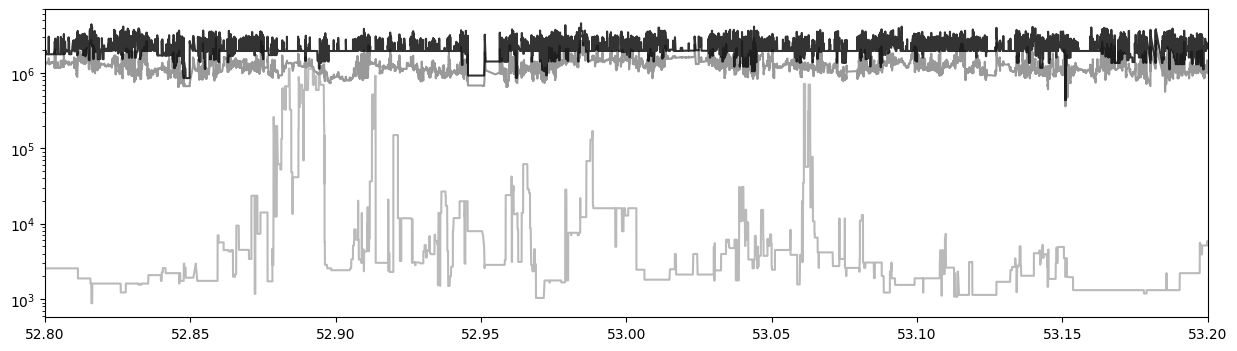

In [508]:
plt.figure(figsize=(15,4))

plt.plot(pos[1:], meanTMRCA_b[:], alpha=0.8, color='grey')
plt.plot(pos[1:], maxTMRCA_b[:], alpha=0.8, color='black')
plt.plot(pos[1:], minTMRCA_b[:], alpha=0.8, color='darkgrey')

plt.yscale('log')
# plt.plot(list(range(50,55,1)), [0.3]*5, 'b--')
plt.xlim(52.80,53.20)

plt.show()

In [405]:
## Look at trees
[x for x in meanTMRCA_w_pmFR if 0<x<0.3]
print([i for i, x in enumerate(meanTMRCA_w_pyYe) if 0<x<0.3])

[3057, 3191, 3192, 3193, 3194, 3195, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3294, 3367, 3368, 3369, 3370, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4068, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4158, 4159, 4160, 4161, 4162, 4179, 4180, 4181, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199, 4200, 4201, 4202, 4203, 4204, 4205, 4206, 4210, 4211, 4212, 4213, 4214, 4215, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 423

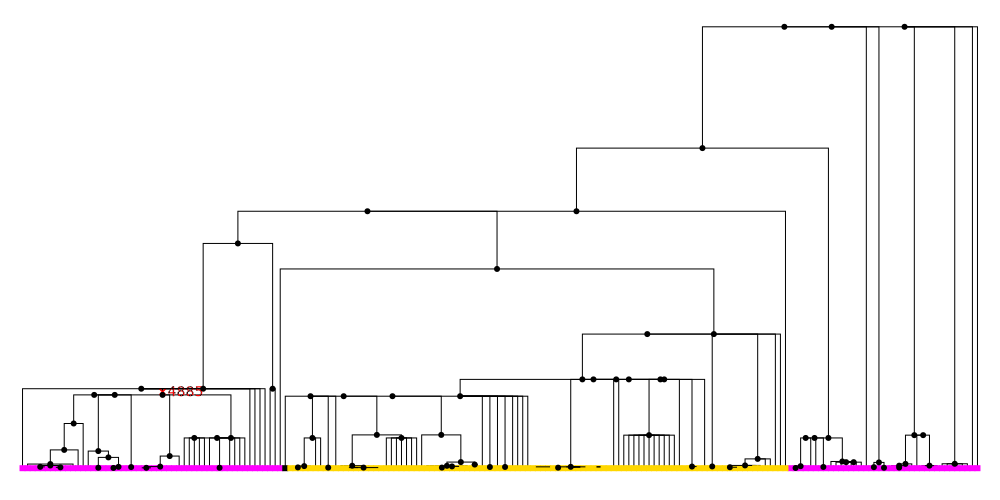

In [406]:
tr = tsD_rosel_pmFRpyYe.at_index(3191)
tr.draw(height=500, width=1000, time_scale='time', node_labels={}, node_colours=combined_dict)

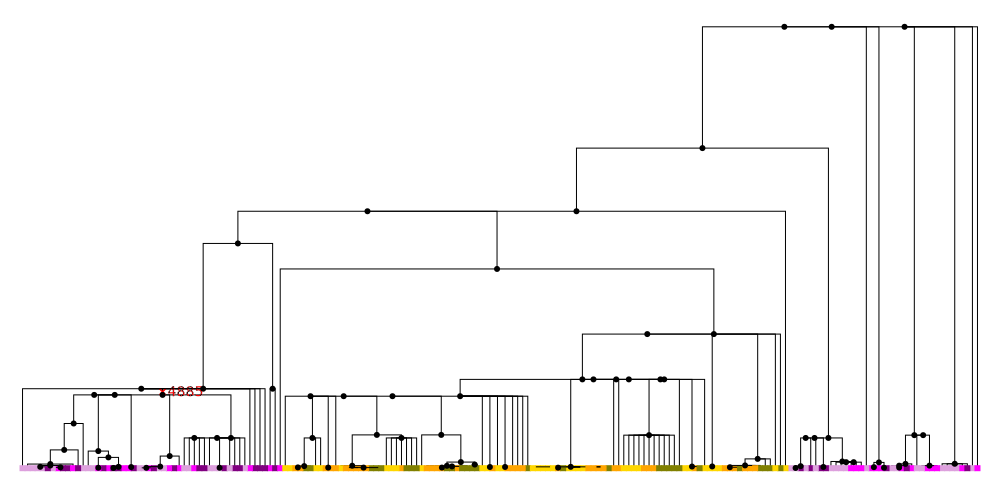

In [425]:
tr = tsD_rosel_pmFRpyYe.at_index(3191)
tr.draw(height=500, width=1000, time_scale='time', node_labels={}, node_colours=combined_dict)